# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
#from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
import zipfile

In [2]:
from sklearn.decomposition import PCA

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [4]:
sns.set_theme()

In [5]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [6]:
# update gdown version
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# !wget 'http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip' -O CIC_IDS_2017.zip
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

In [ ]:
# !unzip MachineLearningCSV.zip
!unzip CIC_IDS_2017.zip

# Carregando os dados

In [ ]:
with zipfile.ZipFile("../../../Dados/CIC_IDS_2017.zip", 'r') as zip_ref:
    zip_ref.extractall("../../../Dados/")

In [9]:
df_list = []
for file in os.listdir('../../../Dados/MachineLearningCVE/'):
  df_aux = pd.read_csv(f'../../../Dados/MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [11]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [12]:
df.columns = df.columns.str.strip()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [14]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2109,80,77,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2257,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2749,443,49,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2862,443,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2877,443,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830701,53,179,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830725,53,161,2,2,82,114,41,41,41.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830726,53,212,2,2,84,162,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830731,443,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [15]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


Registros com valores Null/NaN/NA

In [16]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [17]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
6796,NaN
14739,NaN
15047,NaN
209728,NaN
238569,NaN
...,...
2740049,NaN
2767532,NaN
2791593,NaN
2809052,NaN


In [18]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


In [19]:
df = df.reset_index(drop=True)

Registros com valores não finitos

In [20]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [21]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
65,inf,inf,0
1767,inf,inf,0
1890,inf,inf,0
3365,inf,inf,0
8001,inf,inf,0
...,...,...,...
2515309,inf,inf,0
2515565,inf,inf,0
2516784,inf,inf,0
2516908,inf,inf,0


In [22]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec

# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

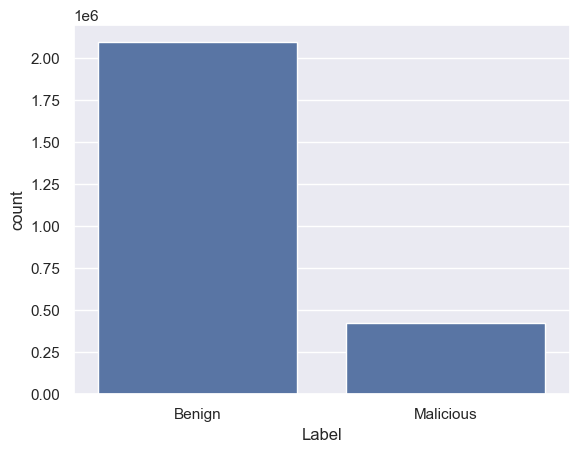

In [23]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [24]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

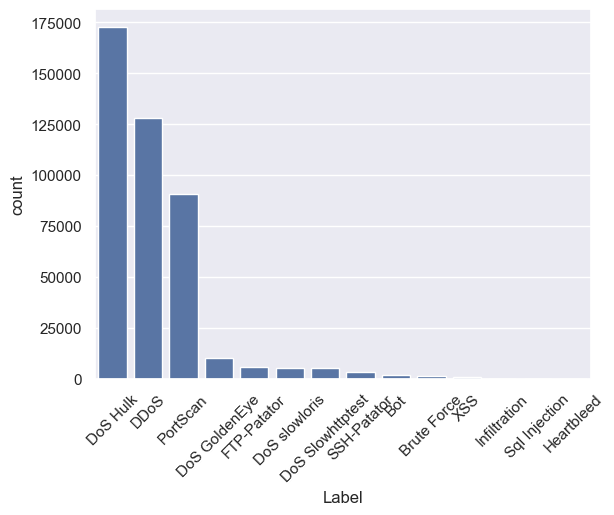

In [25]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Infiltration'),
  Text(1, 0, 'Brute Force'),
  Text(2, 0, 'XSS'),
  Text(3, 0, 'Sql Injection'),
  Text(4, 0, 'Heartbleed')])

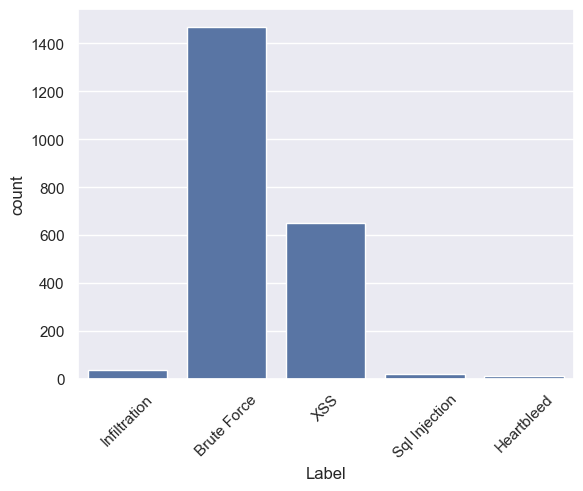

In [26]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [27]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [28]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [29]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [30]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [31]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [32]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [33]:
correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999994),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998390204298),
 (('Total Backward Packets', 'Total Fwd Packets'), 0.9993317736445169)]

In [34]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [35]:
f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Subflow Fwd Packets',
 'Flow Duration',
 'Subflow Bwd Packets',
 'RST Flag Count',
 'Packet Length Mean',
 'Flow IAT Max',
 'Idle Mean',
 'Fwd IAT Total',
 'Max Packet Length',
 'Fwd Packet Length Max',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [36]:
f2drop = f2drop + ['Destination Port']

In [37]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [38]:
# Usando MinMax Scaler dessa vez para que a rede neural seja capaz de gerar saídas no intervalo numérico da função sigmóide

minmax_scaler = MinMaxScaler()
minmax_scaler = minmax_scaler.fit(X_train)

norm_X_train = minmax_scaler.transform(X_train)
norm_X_val = minmax_scaler.transform(X_val)
norm_X_test = minmax_scaler.transform(X_test)

# GANs

<div align="center">

![GAN](https://sthalles.github.io/assets/dcgan/GANs.png)
</div>

Ao invés de ser uma única rede neural, as GANs são uma estrutura que consiste em duas redes neurais: gerador e discriminador. Estas redes têm objetivos diferentes e competem entre si em um processo de treinamento adversarial, de modo que quando uma delas melhora, a outra deve melhorar e acompanhar o ritmo. É como se fossem dois jogadores de xadrez e, quando um deles começa a ganhar, o outro treina um pouco mais para reverter o placar. Como resultado, ambos os jogadores acabam melhorando seu desempenho e alcançando melhores resultados.

**Detecção de intrusão com GANs**.

Embora as GANs tenham sido aplicadas pela primeira vez em imagens, elas podem ser usadas para identificar padrões em qualquer tipo de dados, como fluxos de rede, registros de eventos do Windows e até mesmo medições de sensores em uma fábrica. Assim, se uma GAN for treinada usando apenas dados benignos de redes e sistemas, o gerador vai aprender como esses dados se comportam e como produzir dados semelhantes a ele. O discriminador, por outro lado, aprenderá como distinguir entre dados benignos e dados falsos produzidos pelo gerador. Calma aí! Se o discriminador distingue entre dados benignos reais e falsos, ele identifica anomalias e amostras maliciosas, mesmo que sejam semelhantes aos dados benignos. Portanto, o discriminador da GAN pode ser usado para detectar intrusões. Assim, após o seu treinamento, o discriminador recebe amostras de dados e produz um valor chamado discrimination loss que corresponde a uma probabilidade ou score que indica o quão provável esses dados representam anomalias.

## GAN Tradicional

In [39]:
from tqdm.notebook import tqdm

In [40]:
# Construção do modulo discriminador
# Função de ativação LeakyRelu
# Para saber mais sobre a LeakyRelu: https://paperswithcode.com/method/leaky-relu
# Estrutura da rede
# feat_in -> 120 -> 80 -> 1
class Discriminator(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 120), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(120, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

In [41]:
# Construção do modulo gerador
# Estrutura da rede
# z_dim -> 100 -> 80 -> feat_in
# z_dim é a dimensão do vetor de "random noise" usado como input pro gerador
class Generator(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.gen = nn.Sequential(
      nn.Linear(z_dim, 100), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(100, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, tab_data_dim),
      nn.Sigmoid() # Para garantir que a saída dos valores tabulares está em ]0, 1[
    )

  def forward(self, x):
    return self.gen(x)

### Processo de treinamento da GAN tradicional

<div align="center">

![GAN training](https://miro.medium.com/v2/resize:fit:1358/1*6svU8runkDRjyiIvZ6VKMw.gif)
</div>

In [42]:
# Construção do modulo GAN composto pelo Discriminador e Gerador
class GAN(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device = None):
    super().__init__()
    if not device:
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.z_dim = z_dim
    self.tab_data_dim = tab_data_dim
    self.lrelu_slope = lrelu_slope

    self.discriminator = Discriminator(self.tab_data_dim, self.lrelu_slope).to(self.device)
    self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

  def compile(self, lr):
    assert self.discriminator and self.generator, 'O discriminador e o gerador devem ser inicializados antes de chamar o metodo compile'

    self.optim_discriminator = optim.Adam(self.discriminator.parameters(), lr=lr)
    self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)
    # Utiliza a métrica Binary Cross Entropy
    # Para saber mais: https://medium.com/ensina-ai/uma-explica%C3%A7%C3%A3o-visual-para-fun%C3%A7%C3%A3o-de-custo-binary-cross-entropy-ou-log-loss-eaee662c396c
    self.criterion = nn.BCELoss()

  def fit(self, X, batch_size, num_epochs):
    assert self.optim_discriminator and self.optim_generator and self.criterion, 'O metodo compile deve ser invocado antes de usar o metodo fit'

    for epoch in range(num_epochs):
      print(f'Epoch#{epoch}')
      for batch in tqdm(range(0, len(X), batch_size)):
        real = X[batch:batch+batch_size]
        real = real.view(-1, self.tab_data_dim).to(self.device)
        curr_batch_size = real.shape[0]

        # Treinar o discriminador: maximizar log(D(real)) + log(1 - D(G(z)))

        ## Gera o "random noise" para servir como entrada do discriminador
        noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
        ## Obtém a saida do gerador a partir do "random noise"
        fake = self.generator(noise)

        ## Pega a saida do discriminador a partir da entrada real
        discriminator_real_output = self.discriminator(real).view(-1)
        lossD_real = self.criterion(discriminator_real_output, torch.ones_like(discriminator_real_output))

        discriminator_fake_output = self.discriminator(fake).view(-1)
        lossD_fake = self.criterion(discriminator_fake_output, torch.zeros_like(discriminator_fake_output))

        lossD = (lossD_real + lossD_fake)/2
        self.discriminator.zero_grad()
        lossD.backward(retain_graph=True) # Para manter os gradientes para otimizar o generator
        self.optim_discriminator.step()

        # Treinar o gerador para minimzar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
        output = self.discriminator(fake).view(-1)
        lossG = self.criterion(output, torch.ones_like(output))
        self.generator.zero_grad()
        lossG.backward()
        self.optim_generator.step()

      print(
        f"Epoch [{epoch+1}/{num_epochs}] - Last Loss D: {lossD:.4f}, Last Loss G: {lossG:.4f}"
      )

In [43]:
BATCH_SIZE = 64
LR = 3e-4
Z_DIM = 30
TAB_DATA_DIM = norm_X_train.shape[1]
# Modificar para 1 ou 2 durante a aula para executar mais rapido
NUM_EPOCHS = 2

In [44]:
gan = GAN(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
gan.compile(lr=LR)
print(f'device: {gan.device}')
gan.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS)

device: cpu
Epoch#0


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [1/2] - Last Loss D: 0.4644, Last Loss G: 2.1497
Epoch#1


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [2/2] - Last Loss D: 0.6408, Last Loss G: 1.0256


### Gerando dados artificialmente

In [45]:
def plot_pca(X_real, X_fake):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_real_pca = pca.fit_transform(X_real)
  X_fake_pca = pca.transform(X_fake)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('Redução de Dimensionalidade usando PCA')

  ax.scatter(X_real_pca[:,0], X_real_pca[:,1], s=1, c='green', label='Amostras reais')
  ax.scatter(X_fake_pca[:,0], X_fake_pca[:,1], s=1, c='red', label='Amostras fakes', alpha=0.2)
  ax.legend()

In [46]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, gan.z_dim).to(gan.device)
norm_X_fake = gan.generator(noises).cpu().detach().numpy()

In [47]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

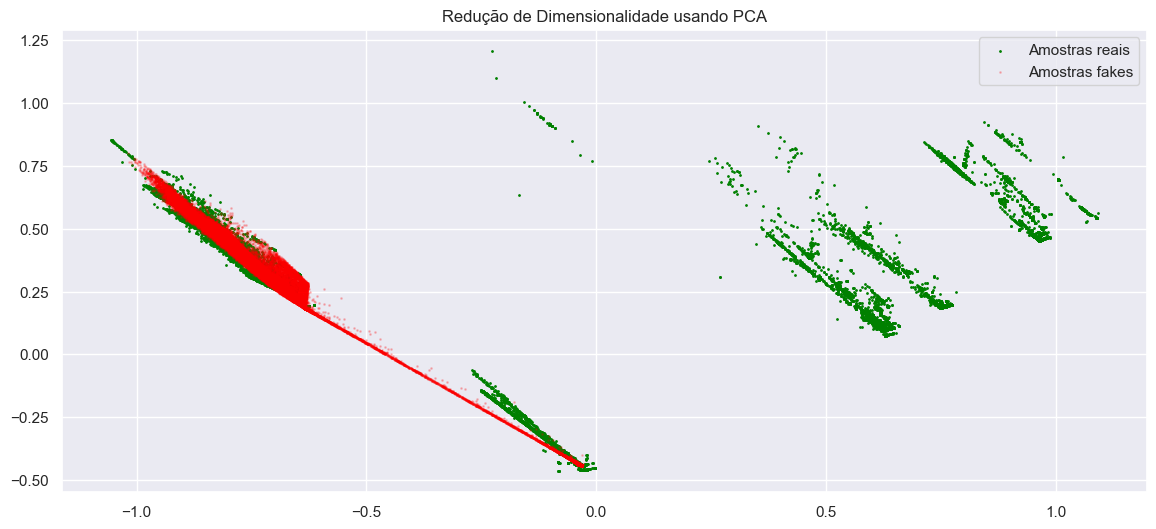

In [48]:
plot_pca(norm_X_train_subset, norm_X_fake)

### Por que será que a GAN não conseguiu performar bem para gerar os dados?
<div align="center">

![thinking](https://i.pinimg.com/236x/a1/af/5e/a1af5eb72e73424b0afe12a777949464.jpg)
</div>



## Uma possível solução - WGAN com Gradient Penalty

A Wasserstein GAN é considerada como uma extensão da rede Generativa Adversarial introduzida por Ian Goodfellow. A WGAN foi introduzida por Martin Arjovsky em 2017 e promete melhorar tanto a estabilidade no treinamento do modelo quanto introduzir uma função de perda que seja capaz de se correlacionar com a qualidade dos eventos gerados.

Em vez de usar o conceito de "discriminador", a WGAN usa o conceito de "crítico", pois o mesmo vai fornecer como saída um número real qualquer, que não esteja delimitado em um intervalo que aponta o quanto as amostras geradas artificialmente são diferentes das reais, diferente do antigo discriminador, que fornecia saídas probabilistícas entre [0, 1]

**As principais diferenças introduzidas pela WGAN são**:

1. Usar uma nova função de perda derivada da distância de Wasserstein (WLoss).
2. Após cada atualização de gradiente na função crítica, fixar os pesos a uma pequena faixa fixa, [-c,c]. Isto permite aplicar a restrição de Lipschitz.
Alternativa proposta ao Discriminador — o Crítico.
3. Uso de uma função de ativação linear como a linear de saída da rede do Critic.
4. Número diferente de atualizações para o Gerador e para o crítico.

**Os principais benefícios da WGAN são**:
- Treinamento mais estável do que o da GAN tradicional
- Reduz os problemas de *mode collapse* da GAN tradicional
- Reduz o problema de *vanishing gradients* da GAN tradicional
- Menos sensível e impactada por hiperparâmetros e arquiteturas das redes do que a GAN tradicional

In [49]:
# Modulo "crítico"
class Critic(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 120), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(120, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, 1),
      # Percebam que não tem a função de ativação sigmoide
    )

  def forward(self, x):
    return self.disc(x)

class WGANGP(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device = None):
    super().__init__()
    if not device:
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.z_dim = z_dim
    self.tab_data_dim = tab_data_dim
    self.lrelu_slope = lrelu_slope

    self.critic = Critic(self.tab_data_dim, self.lrelu_slope).to(self.device)
    self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

    # Opcional: usado para testes
    self.fixed_noise = None
    self.step = 0

  def compile(self, lr):
    assert self.critic and self.generator, 'Critic and generator must be initialized before using compile method.'

    self.optim_critic = optim.Adam(self.critic.parameters(), lr=lr)
    self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)

  # Uma das diferenças da WGAN
  def gradient_penalty(self, real, fake):
    batch_size = real.shape[0]
    epsilon = torch.rand(real.shape).to(self.device)
    interpolated_data = real*epsilon + (1 - epsilon)*fake

    # Calcular escores da imagem interpolada usando o crítico
    interpolated_scores = self.critic(interpolated_data)

    # Calcular o gradiente dos escores da imagem interpolada
    gradient = torch.autograd.grad(
        inputs = interpolated_data,
        outputs = interpolated_scores,
        grad_outputs = torch.ones_like(interpolated_scores),
        create_graph = True,
        retain_graph = True
    )[0]

    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    return gradient_penalty

  def fit(self, X, batch_size, num_epochs, critic_iterations=5, lambda_gp = 0.05):
    assert self.optim_critic and self.optim_generator, 'Compile method must be called before using fit method.'

    # Opcional: usado apenas para testes
    if self.fixed_noise is None:
      self.fixed_noise = torch.randn((8, self.z_dim)).to(self.device)

    for epoch in range(num_epochs):
      print(f'Epoch#{epoch}')
      for batch in tqdm(range(0, len(X), batch_size)):
        real = X[batch:batch+batch_size]
        real = real.view(-1, self.tab_data_dim).to(self.device)
        curr_batch_size = real.shape[0]

        # Treinar o critico: maximizar a Earth's Mover Distance (ou minimizar o oposto da mesma)
        for _ in range(critic_iterations):
          noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
          fake = self.generator(noise)

          critic_real_output = self.critic(real).view(-1)
          critic_fake_output = self.critic(fake).view(-1)

          gp = self.gradient_penalty(real, fake)
          lossC = -(torch.mean(critic_real_output) - torch.mean(critic_fake_output)) + lambda_gp*gp
          self.critic.zero_grad()
          lossC.backward(retain_graph=True) # Para manter os gradientes para otimizar o generator
          self.optim_critic.step()

        # Treinar o gerador para minimzar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
        output = self.critic(fake).view(-1)
        lossG = -torch.mean(output)
        self.generator.zero_grad()
        lossG.backward()
        self.optim_generator.step()

      print(
        f"Epoch [{epoch+1}/{num_epochs}] - Last Loss C: {lossC:.4f}, Last Loss G: {lossG:.4f}"
      )

In [50]:
wgangp = WGANGP(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
wgangp.compile(lr=LR)
print(f'device: {wgangp.device}')
wgangp.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=2)

device: cpu
Epoch#0


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [1/2] - Last Loss C: -0.0164, Last Loss G: -0.2181
Epoch#1


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [2/2] - Last Loss C: -0.3031, Last Loss G: -0.0007


In [51]:
# ---> Rode essa célula para baixar modelo pré-treinado <---

#!wget 'https://drive.usercontent.google.com/download?id=14iRVOF-orDJKVjXH5d9_PbJKcz1m0mvb&export=download&authuser=0&confirm=t&uuid=2c68ccd7-19a9-4afa-91de-349ad4073192&#at=APZUnTUsI1aMOXcIGpQAiQeCTMfs:1705153857727' -O 'pretrained_wgangp.pt'
#wgangp = torch.load('pretrained_wgangp.pt')

### Gerando dados artificialmente

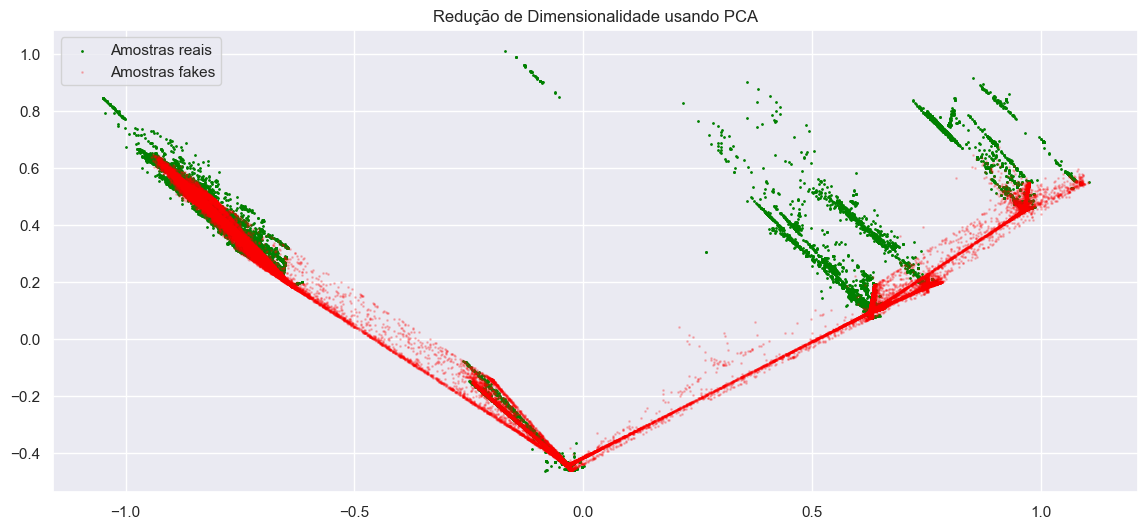

In [52]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, wgangp.z_dim).to(wgangp.device)
norm_X_wgangp_fake = wgangp.generator(noises).cpu().detach().numpy()

random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

plot_pca(norm_X_train_subset, norm_X_wgangp_fake)

# Definindo um threshold e avaliando resultados

In [53]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [54]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [55]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [56]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação - GAN Tradicional

In [57]:
val_scores_gan = gan.discriminator(torch.tensor(norm_X_val, dtype=torch.float).to(gan.device))
val_scores_gan = val_scores_gan.cpu().detach().numpy()

anomaly_score_gan = 1 - val_scores_gan # Pois a saida do discriminador da GAN aponta a probabilidade de uma instância ser REAL (benigna). Podemos estimar a probabilidade da instância x ser maliciosa com 1 - D(x)

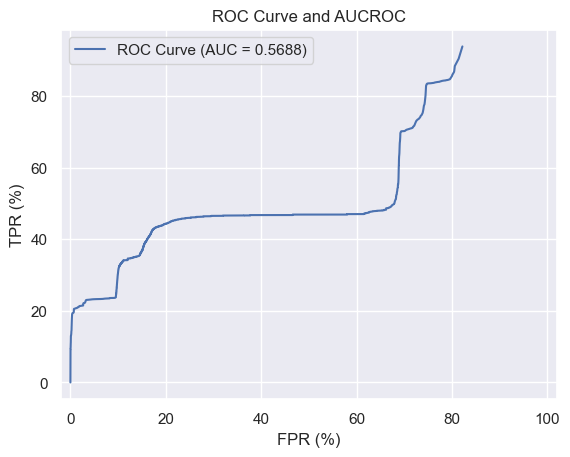

In [58]:
plot_roc_curve(y_val, anomaly_score_gan)

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_gan)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.4')

,fpr,tpr,thresholds,youden-index
15702,0.175946,0.430751,0.628428,0.254805
15660,0.174893,0.429604,0.630619,0.254710
15662,0.174903,0.429610,0.630606,0.254707
15704,0.176065,0.430758,0.628141,0.254692
15664,0.174934,0.429624,0.630502,0.254690
...,...,...,...,...
248,0.000078,0.019590,0.999817,0.019512
69,0.000075,0.001818,0.999957,0.001743
27,0.000072,0.000825,0.999995,0.000754
2,0.000065,0.000335,1.000000,0.000271


In [60]:
GAN_BEST_VALIDATION_THRESHOLD = 0.736793

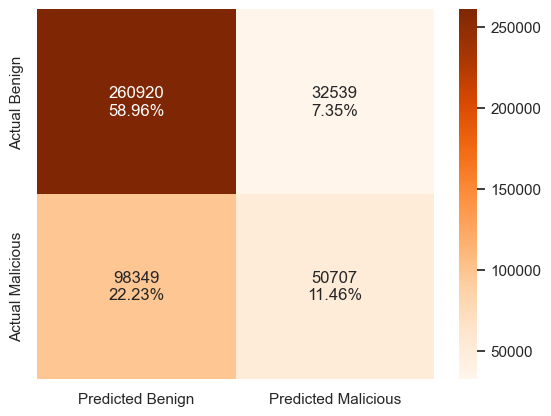

In [61]:
plot_confusion_matrix(y_val, anomaly_score_gan > GAN_BEST_VALIDATION_THRESHOLD)

In [62]:
get_overall_metrics(y_val, val_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

{'acc': 0.6166367241788414,
 'tpr': 0.5101035852297123,
 'fpr': 0.3292521272136823,
 'precision': 0.44037855620424426,
 'f1-score': 0.47268364251255784}

In [63]:
get_tpr_per_attack(classes_val, (val_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.8420722031208675,
 'DDoS': 0.4798241306967817,
 'PortScan': 0.0040897222134835,
 'DoS GoldenEye': 0.2872222222222222,
 'FTP-Patator': 0.33622350674373797,
 'DoS slowloris': 0.3257294429708223,
 'DoS Slowhttptest': 0.3901639344262295,
 'SSH-Patator': 0.07364685004436557,
 'Bot': 0.3718887262079063,
 'Brute Force': 0.08171206225680934,
 'XSS': 0.03070175438596491,
 'Infiltration': 1.0,
 'Sql Injection': 0.5714285714285714,
 'Heartbleed': 0.0}

## Conjunto de validação - WGANGP

In [64]:
val_scores_wgangp = wgangp.critic(torch.tensor(norm_X_val, dtype=torch.float).to(wgangp.device))
val_scores_wgangp = val_scores_wgangp.cpu().detach().numpy()

anomaly_score_wgangp = -val_scores_wgangp

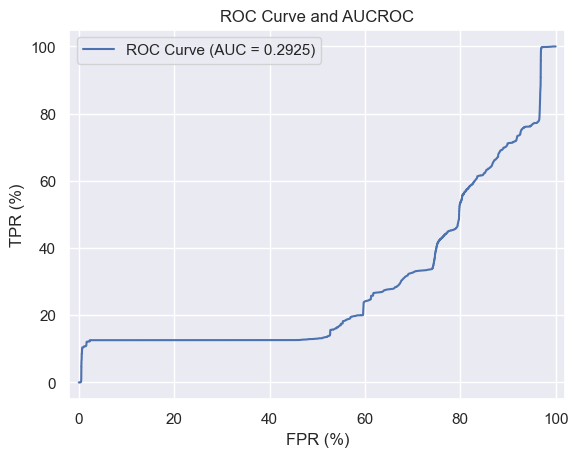

In [65]:
plot_roc_curve(y_val, anomaly_score_wgangp)

In [66]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_wgangp)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.15')

,fpr,tpr,thresholds,youden-index
2597,0.016479,0.120988,0.255548,0.104509
2595,0.016476,0.120968,0.255982,0.104492
2603,0.016534,0.121022,0.253960,0.104488
2601,0.016530,0.121015,0.254118,0.104485
2593,0.016472,0.120955,0.256099,0.104482
...,...,...,...,...
9066,0.149881,0.126040,-0.059849,-0.023841
9067,0.149909,0.126040,-0.059851,-0.023869
9068,0.149915,0.126040,-0.059851,-0.023875
9069,0.149929,0.126040,-0.059852,-0.023889


In [67]:
WGANGP_BEST_VALIDATION_THRESHOLD = 0.250947

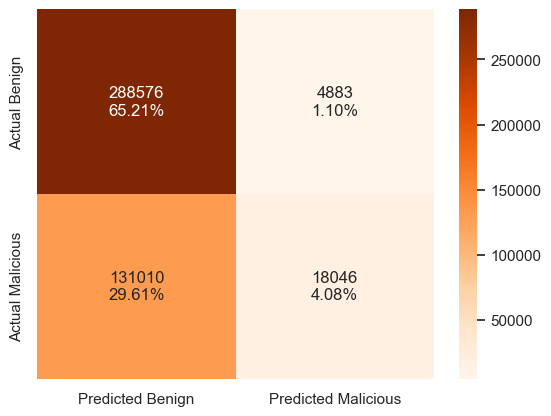

In [68]:
plot_confusion_matrix(y_val, anomaly_score_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [69]:
get_overall_metrics(y_val, val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.6268420279538547,
 'tpr': 0.8686936453413482,
 'fpr': 0.49600114496403247,
 'precision': 0.470782431646306,
 'f1-score': 0.6106353278502981}

In [70]:
get_tpr_per_attack(classes_val, (val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.7005091245702195,
 'DDoS': 1.0,
 'PortScan': 0.9978293012866896,
 'DoS GoldenEye': 0.9080555555555555,
 'FTP-Patator': 1.0,
 'DoS slowloris': 0.656763925729443,
 'DoS Slowhttptest': 0.7781420765027323,
 'SSH-Patator': 0.9991126885536823,
 'Bot': 1.0,
 'Brute Force': 1.0,
 'XSS': 1.0,
 'Infiltration': 1.0,
 'Sql Injection': 1.0,
 'Heartbleed': 1.0}

## Conjunto de teste - GAN Tradicional

In [71]:
test_scores_gan = gan.discriminator(torch.tensor(norm_X_test, dtype=torch.float).to(gan.device))
test_scores_gan = test_scores_gan.cpu().detach().numpy()

test_anomaly_scores_gan = 1 - test_scores_gan

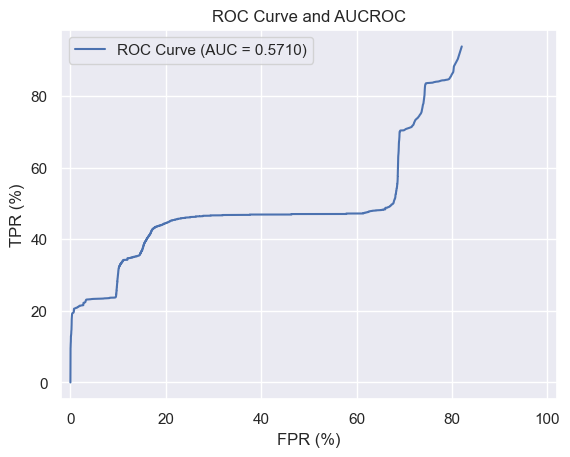

In [72]:
plot_roc_curve(y_test, test_anomaly_scores_gan)

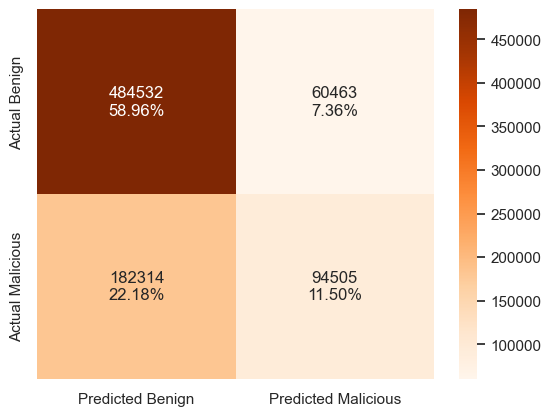

In [73]:
plot_confusion_matrix(y_test, test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

In [74]:
get_overall_metrics(y_test, test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)

{'acc': 0.7045840056265773,
 'tpr': 0.34139636368890863,
 'fpr': 0.11094230222295617,
 'precision': 0.6098355789582366,
 'f1-score': 0.4377389777830273}

In [75]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_gan > GAN_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.12319537160658656,
 'DDoS': 0.5053479149140728,
 'PortScan': 0.44821452771378234,
 'DoS GoldenEye': 0.7171702064014358,
 'FTP-Patator': 0.6728026963961629,
 'DoS slowloris': 0.05057142857142857,
 'DoS Slowhttptest': 0.5400235432607416,
 'SSH-Patator': 0.9249521988527725,
 'Bot': 0.5834645669291338,
 'Brute Force': 0.049163179916317995,
 'XSS': 0.030660377358490566,
 'Infiltration': 0.13043478260869565,
 'Sql Injection': 0.6428571428571429,
 'Heartbleed': 0.7142857142857143}

## Conjunto de teste - WGANGP

In [76]:
test_scores_wgangp = wgangp.critic(torch.tensor(norm_X_test, dtype=torch.float).to(wgangp.device))
test_scores_wgangp = test_scores_wgangp.cpu().detach().numpy()

test_anomaly_scores_wgapgp = -test_scores_wgangp

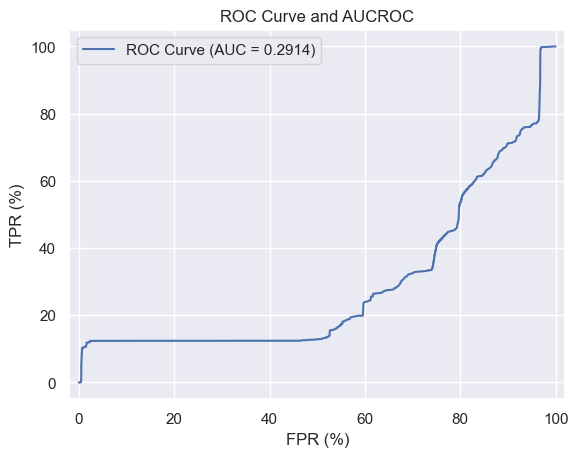

In [77]:
plot_roc_curve(y_test, test_anomaly_scores_wgapgp)

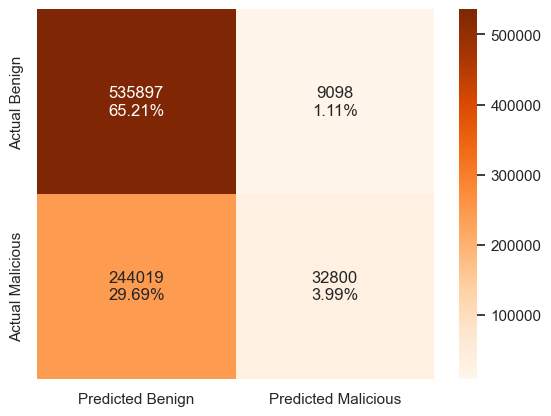

In [78]:
plot_confusion_matrix(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [79]:
get_overall_metrics(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.6920020831964411,
 'tpr': 0.11848897655146504,
 'fpr': 0.016693731135148028,
 'precision': 0.7828535968303977,
 'f1-score': 0.20582523053367094}

In [80]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.28514463729417,
 'DDoS': 0.0,
 'PortScan': 0.0013043772868952432,
 'DoS GoldenEye': 0.0,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.019714285714285715,
 'DoS Slowhttptest': 0.18157739846968804,
 'SSH-Patator': 0.0,
 'Bot': 0.0,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 0.14285714285714285}

# Perguntas

## 1. Explique como é esperado, na teoria, que modelos basedos em GANs realizem detecção de anomalias.

Ao treinar uma GAN com dados BENIGNOS, um gerador se torna mais eficiente em gerar dados benignos, enquanto um discriminador se torna mais eficiente em detectar se um dado é benigno ou não, desta forma, um discriminador pode ser treinado para detectar dados malignos (quando não discriminar o dado como benigno). É assim que um discriminador pode ser usado para detectar intrusões.

## 2. Através da redução de dimensionalidade, é possível observar que os dados gerados pela GAN tradicional possuem uma diferença para os dados gerados pela WGAN. O que você observou como diferente nos dados gerados pela WGAN? Por que isso aconteceu?

Na GAN tradicional, o que mais achei destacável foi o fato de não ter nenhum dado falso a partir do ponto 0 no eixo das abscissas, ou seja, na metade direita da imagem do plot, dando a impressão que a GAN tradicional falhou em representar dados falsos com aquelas características, pois logo em seguida a WGAN faz um plot mais estável e que faz mais sentido, mostrando esse tipo de dado falso.

Além disso, no plot da WGAN, eu notei que parece existir duas retas diagonais(função afim) que parecem representar os dados mais falsos, como se quanto mais próximo daquelas retas, maior chance do dado ser falso, isso é notável também porque existem muitos dados verdadeiros cercando esses dados falsos que estão nestas retas. Já na GAN tradicional, só existia uma reta dessa no plot.

GAN tradicional:

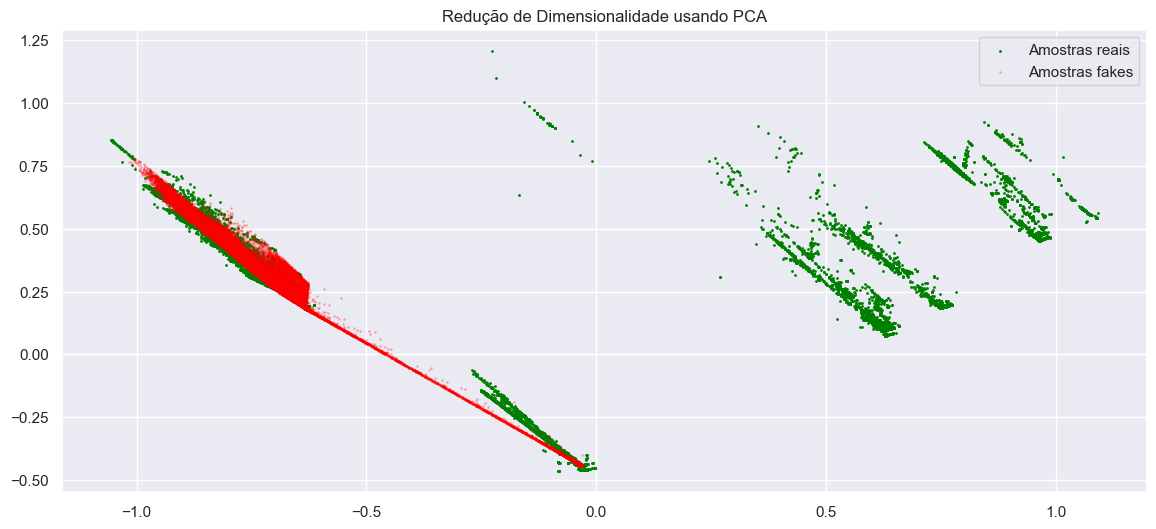

WGAN:

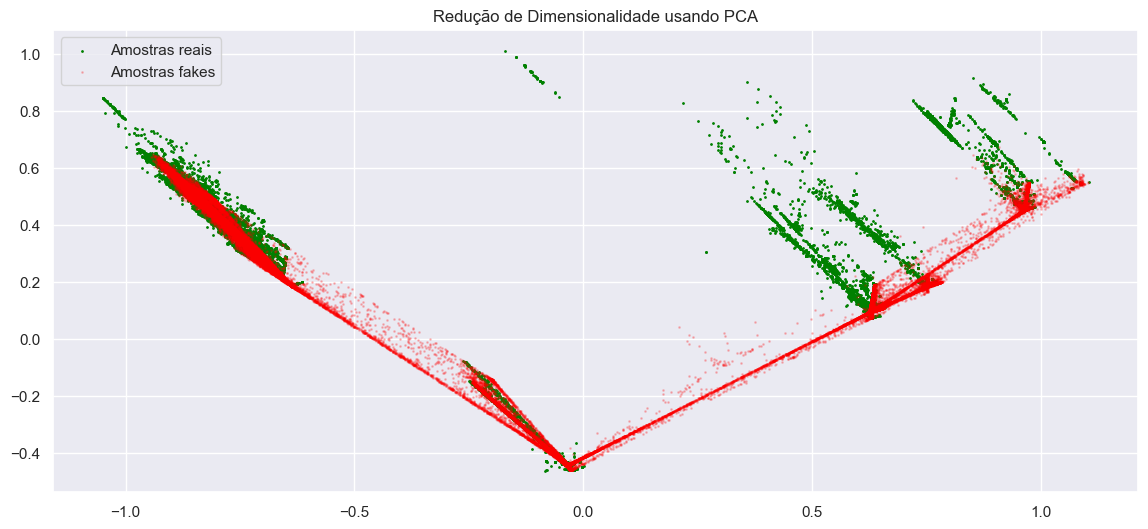

## 3. Explique possíveis razões para que a WGAN deu melhores resultados para detecção de anomalias em comparação com a GAN tradicional.

(Por algum motivo, na minha máquina os resultados foram diferentes, mesmo sem eu ter mudado o código, mas vou considerar os valores mostrados na aula)

As WGANs tendem a ter um treinamento mais estável em comparação com as GANs tradicionais, isso se deve principalmente ao uso da função de perda de distância de Wasserstein, que produz gradientes mais suaves e evita problemas como o modo collapse, onde a GAN tradicional pode gerar apenas algumas amostras dominantes. As WGANs mitigam o problema de vanishing gradients, que é comum em GANs tradicionais. Ao usar a distância de Wasserstein como função de perda, as WGANs produzem gradientes mais estáveis e evitam que eles se aproximem de zero durante o treinamento, o que pode levar a um treinamento mais eficaz e estável. A função de perda de distância de Wasserstein tem propriedades matemáticas que estão mais correlacionadas com a qualidade das amostras geradas. Isso significa que o discriminador em uma WGAN é capaz de fornecer um feedback mais preciso para o gerador, permitindo que ele produza amostras de maior qualidade ao longo do tempo. As WGANs são menos sensíveis aos hiperparâmetros do modelo em comparação com as GANs tradicionais. Isso ocorre porque a função de perda de distância de Wasserstein não requer uma sintonia tão precisa de hiperparâmetros, tornando o processo de treinamento mais robusto e menos dependente de ajustes finos. Mode collapse é um problema comum em GANs tradicionais, onde o gerador produz apenas algumas amostras dominantes, ignorando a diversidade do espaço de dados. As WGANs têm uma menor probabilidade de sofrer de mode collapse devido à sua estabilidade de treinamento e à capacidade do discriminador de fornecer feedback mais informativo para o gerador.

Não sei dizer exatamente quais destes motivos influenciaram mais ou menos nos resultados, acho que é um nível de abstração muito específico, provavelmente foi uma junção de todos os fatores.

# Atividade de código

## Refaça o código da WGAN com Gradient Penalty considerando que as redes do discriminador e gerador tenham apenas UMA camada interna antes da camada de saída e avalie os resultados

In [81]:
# Modulo "crítico"
class Critic(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 120), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(120, 80), # Layer 2
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(80, 1),
      # Percebam que não tem a função de ativação sigmoide
    )

  def forward(self, x):
    return self.disc(x)
  
class Generator(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.gen = nn.Sequential(
      nn.Linear(z_dim, 100), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(100, tab_data_dim),
      nn.Sigmoid() # Para garantir que a saída dos valores tabulares está em ]0, 1[
    )

  def forward(self, x):
    return self.gen(x)
  
class Discriminator(nn.Module):
  def __init__(self, tab_data_dim, lrelu_slope = 0.1):
    super().__init__()

    self.disc = nn.Sequential(
      nn.Linear(tab_data_dim, 100), # Layer 1
      nn.LeakyReLU(lrelu_slope),
      nn.Linear(100, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.disc(x)

class WGANGP(nn.Module):
  def __init__(self, z_dim, tab_data_dim, lrelu_slope=0.1, device = None):
    super().__init__()
    if not device:
      self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.z_dim = z_dim
    self.tab_data_dim = tab_data_dim
    self.lrelu_slope = lrelu_slope

    self.critic = Critic(self.tab_data_dim, self.lrelu_slope).to(self.device)
    self.generator = Generator(self.z_dim, tab_data_dim, self.lrelu_slope).to(self.device)

    # Opcional: usado para testes
    self.fixed_noise = None
    self.step = 0

  def compile(self, lr):
    assert self.critic and self.generator, 'Critic and generator must be initialized before using compile method.'

    self.optim_critic = optim.Adam(self.critic.parameters(), lr=lr)
    self.optim_generator = optim.Adam(self.generator.parameters(), lr=lr)

  # Uma das diferenças da WGAN
  def gradient_penalty(self, real, fake):
    batch_size = real.shape[0]
    epsilon = torch.rand(real.shape).to(self.device)
    interpolated_data = real*epsilon + (1 - epsilon)*fake

    # Calcular escores da imagem interpolada usando o crítico
    interpolated_scores = self.critic(interpolated_data)

    # Calcular o gradiente dos escores da imagem interpolada
    gradient = torch.autograd.grad(
        inputs = interpolated_data,
        outputs = interpolated_scores,
        grad_outputs = torch.ones_like(interpolated_scores),
        create_graph = True,
        retain_graph = True
    )[0]

    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1)**2)
    return gradient_penalty

  def fit(self, X, batch_size, num_epochs, critic_iterations=5, lambda_gp = 0.05):
    assert self.optim_critic and self.optim_generator, 'Compile method must be called before using fit method.'

    # Opcional: usado apenas para testes
    if self.fixed_noise is None:
      self.fixed_noise = torch.randn((8, self.z_dim)).to(self.device)

    for epoch in range(num_epochs):
      print(f'Epoch#{epoch}')
      for batch in tqdm(range(0, len(X), batch_size)):
        real = X[batch:batch+batch_size]
        real = real.view(-1, self.tab_data_dim).to(self.device)
        curr_batch_size = real.shape[0]

        # Treinar o critico: maximizar a Earth's Mover Distance (ou minimizar o oposto da mesma)
        for _ in range(critic_iterations):
          noise = torch.randn(curr_batch_size, self.z_dim).to(self.device)
          fake = self.generator(noise)

          critic_real_output = self.critic(real).view(-1)
          critic_fake_output = self.critic(fake).view(-1)

          gp = self.gradient_penalty(real, fake)
          lossC = -(torch.mean(critic_real_output) - torch.mean(critic_fake_output)) + lambda_gp*gp
          self.critic.zero_grad()
          lossC.backward(retain_graph=True) # Para manter os gradientes para otimizar o generator
          self.optim_critic.step()

        # Treinar o gerador para minimzar log(1 - D(G(z))) <-> maximizar log(D(G(z)))
        output = self.critic(fake).view(-1)
        lossG = -torch.mean(output)
        self.generator.zero_grad()
        lossG.backward()
        self.optim_generator.step()

      print(
        f"Epoch [{epoch+1}/{num_epochs}] - Last Loss C: {lossC:.4f}, Last Loss G: {lossG:.4f}"
      )

In [82]:
wgangp = WGANGP(z_dim=Z_DIM, tab_data_dim=TAB_DATA_DIM)
wgangp.compile(lr=LR)
print(f'device: {wgangp.device}')
wgangp.fit(X=torch.tensor(norm_X_train, dtype=torch.float), batch_size=BATCH_SIZE, num_epochs=2)

device: cpu
Epoch#0


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [1/2] - Last Loss C: 0.0236, Last Loss G: -1.6929
Epoch#1


  0%|          | 0/19652 [00:00<?, ?it/s]

Epoch [2/2] - Last Loss C: -0.0470, Last Loss G: -1.8061


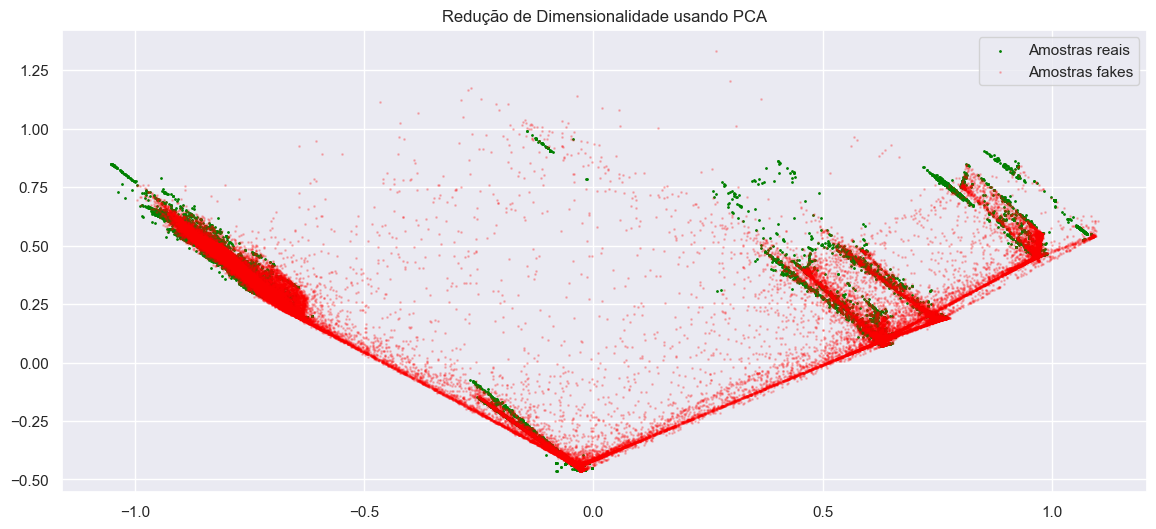

In [83]:
QTD_INSTANCES = 100000

noises = torch.randn(QTD_INSTANCES, wgangp.z_dim).to(wgangp.device)
norm_X_wgangp_fake = wgangp.generator(noises).cpu().detach().numpy()

random_train_indexes = np.random.choice(norm_X_train.shape[0], QTD_INSTANCES, replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

plot_pca(norm_X_train_subset, norm_X_wgangp_fake)

## Conjunto de validação - WGANGP

In [84]:
val_scores_wgangp = wgangp.critic(torch.tensor(norm_X_val, dtype=torch.float).to(wgangp.device))
val_scores_wgangp = val_scores_wgangp.cpu().detach().numpy()

anomaly_score_wgangp = -val_scores_wgangp

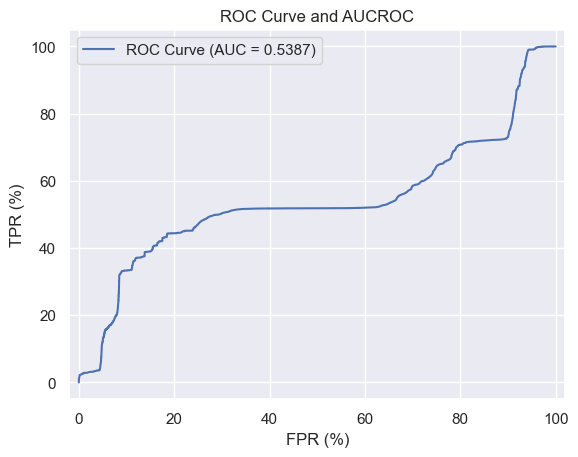

In [85]:
plot_roc_curve(y_val, anomaly_score_wgangp)

In [86]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_wgangp)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.15')

,fpr,tpr,thresholds,youden-index
17131,0.119301,0.370049,-1.728393,0.250748
17128,0.119291,0.370035,-1.728391,0.250744
17130,0.119298,0.370042,-1.728393,0.250744
17133,0.119311,0.370056,-1.728395,0.250744
17135,0.119318,0.370062,-1.728396,0.250744
...,...,...,...,...
4043,0.043383,0.036275,-1.637225,-0.007108
4016,0.043216,0.036101,-1.637118,-0.007115
4041,0.043369,0.036248,-1.637207,-0.007121
4039,0.043366,0.036241,-1.637206,-0.007124


In [87]:
WGANGP_BEST_VALIDATION_THRESHOLD = 0.250947

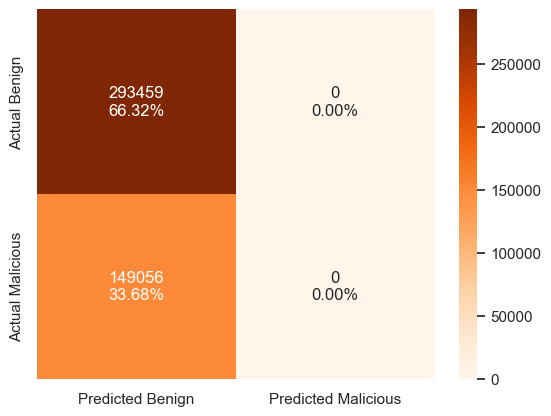

In [88]:
plot_confusion_matrix(y_val, anomaly_score_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [89]:
get_overall_metrics(y_val, val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.3368382992666915,
 'tpr': 1.0,
 'fpr': 1.0,
 'precision': 0.3368382992666915,
 'f1-score': 0.5039327485627253}

In [90]:
get_tpr_per_attack(classes_val, (val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 1.0,
 'DDoS': 1.0,
 'PortScan': 1.0,
 'DoS GoldenEye': 1.0,
 'FTP-Patator': 1.0,
 'DoS slowloris': 1.0,
 'DoS Slowhttptest': 1.0,
 'SSH-Patator': 1.0,
 'Bot': 1.0,
 'Brute Force': 1.0,
 'XSS': 1.0,
 'Infiltration': 1.0,
 'Sql Injection': 1.0,
 'Heartbleed': 1.0}

## Conjunto de teste - WGANGP

In [91]:
test_scores_wgangp = wgangp.critic(torch.tensor(norm_X_test, dtype=torch.float).to(wgangp.device))
test_scores_wgangp = test_scores_wgangp.cpu().detach().numpy()

test_anomaly_scores_wgapgp = -test_scores_wgangp

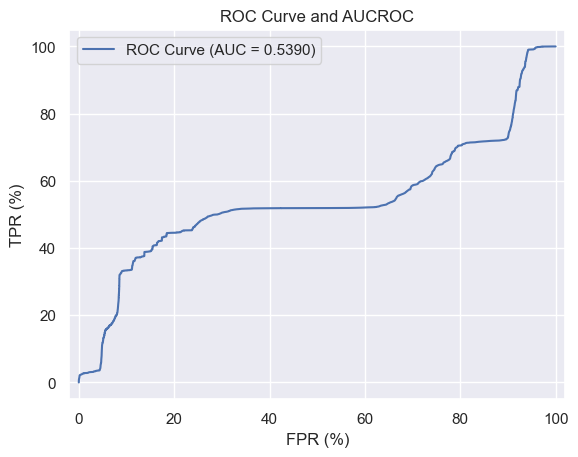

In [92]:
plot_roc_curve(y_test, test_anomaly_scores_wgapgp)

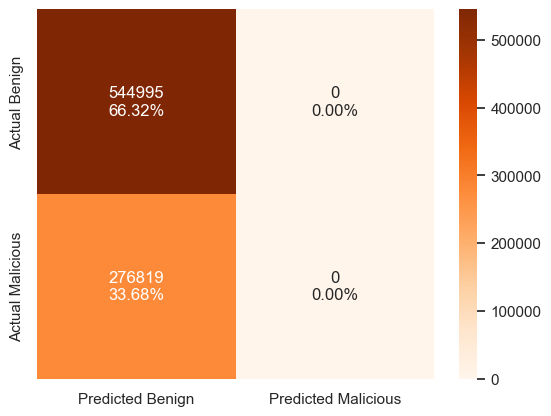

In [93]:
plot_confusion_matrix(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [94]:
get_overall_metrics(y_test, test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)

C:\Users\henri\AppData\Local\Temp\ipykernel_73224\1432429288.py:6: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


{'acc': 0.6631610072352138,
 'tpr': 0.0,
 'fpr': 0.0,
 'precision': nan,
 'f1-score': nan}

In [95]:
get_tpr_per_attack(classes_test, (test_anomaly_scores_wgapgp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 0.0,
 'DDoS': 0.0,
 'PortScan': 0.0,
 'DoS GoldenEye': 0.0,
 'FTP-Patator': 0.0,
 'DoS slowloris': 0.0,
 'DoS Slowhttptest': 0.0,
 'SSH-Patator': 0.0,
 'Bot': 0.0,
 'Brute Force': 0.0,
 'XSS': 0.0,
 'Infiltration': 0.0,
 'Sql Injection': 0.0,
 'Heartbleed': 0.0}

In [96]:
val_scores_wgangp = wgangp.critic(torch.tensor(norm_X_val, dtype=torch.float).to(wgangp.device))
val_scores_wgangp = val_scores_wgangp.cpu().detach().numpy()

anomaly_score_wgangp = -val_scores_wgangp

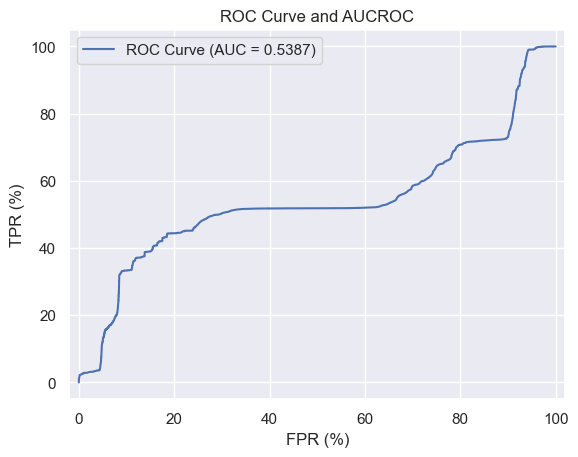

In [97]:
plot_roc_curve(y_val, anomaly_score_wgangp)

In [98]:
fpr, tpr, thresholds = roc_curve(y_val, anomaly_score_wgangp)
df_val_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds})
df_val_roc['youden-index'] = df_val_roc['tpr'] - df_val_roc['fpr']
df_val_roc.sort_values('youden-index', ascending=False).drop_duplicates('fpr').query('fpr < 0.15')

,fpr,tpr,thresholds,youden-index
17131,0.119301,0.370049,-1.728393,0.250748
17128,0.119291,0.370035,-1.728391,0.250744
17130,0.119298,0.370042,-1.728393,0.250744
17133,0.119311,0.370056,-1.728395,0.250744
17135,0.119318,0.370062,-1.728396,0.250744
...,...,...,...,...
4043,0.043383,0.036275,-1.637225,-0.007108
4016,0.043216,0.036101,-1.637118,-0.007115
4041,0.043369,0.036248,-1.637207,-0.007121
4039,0.043366,0.036241,-1.637206,-0.007124


In [99]:
WGANGP_BEST_VALIDATION_THRESHOLD = 0.250947

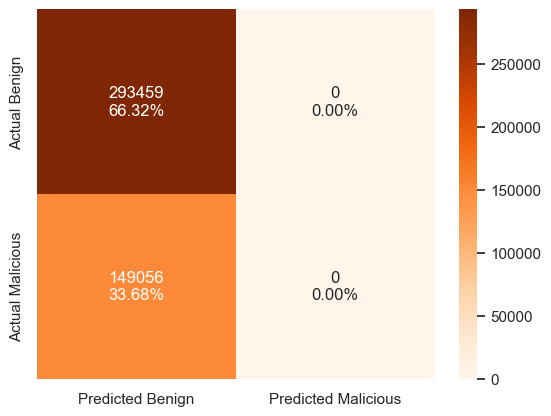

In [100]:
plot_confusion_matrix(y_val, anomaly_score_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

In [101]:
get_overall_metrics(y_val, val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)

{'acc': 0.3368382992666915,
 'tpr': 1.0,
 'fpr': 1.0,
 'precision': 0.3368382992666915,
 'f1-score': 0.5039327485627253}

In [102]:
get_tpr_per_attack(classes_val, (val_scores_wgangp > WGANGP_BEST_VALIDATION_THRESHOLD)[:,0])

{'DoS Hulk': 1.0,
 'DDoS': 1.0,
 'PortScan': 1.0,
 'DoS GoldenEye': 1.0,
 'FTP-Patator': 1.0,
 'DoS slowloris': 1.0,
 'DoS Slowhttptest': 1.0,
 'SSH-Patator': 1.0,
 'Bot': 1.0,
 'Brute Force': 1.0,
 'XSS': 1.0,
 'Infiltration': 1.0,
 'Sql Injection': 1.0,
 'Heartbleed': 1.0}